# Часть 1

## Этап 1

In [65]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklift.datasets import fetch_hillstrom
from sklift.metrics import uplift_at_k, qini_auc_score

import warnings
warnings.filterwarnings('ignore')

# Загрузка датасета Hillstrom
data = fetch_hillstrom(target_col='visit', return_X_y_t=True)
X, y, treatment = data

# Объединяем всё в единый DataFrame для удобства анализа
df = X.copy()
df['treatment'] = treatment
df['target'] = y

print(f'Размер датасета: {df.shape}')
print(f'\nТипы данных:')
print(df.dtypes)
print(f'\nПервые 5 строк:')
df.head()

Размер датасета: (64000, 10)

Типы данных:
recency              int64
history_segment        str
history            float64
mens                 int64
womens               int64
zip_code               str
newbie               int64
channel                str
treatment              str
target               int64
dtype: object

Первые 5 строк:


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


In [66]:
# Проверка на пропуски
print('Пропуски в данных:')
print(df.isnull().sum())
print(f'\nОбщее количество пропусков: {df.isnull().sum().sum()}')

Пропуски в данных:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64

Общее количество пропусков: 0


In [67]:
# Заполнение пропусков (если есть)
# Для числовых — медианой, для категориальных — модой
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())
        print(f'Заполнены пропуски в числовом столбце "{col}" медианой')

for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f'Заполнены пропуски в категориальном столбце "{col}" модой')

if df.isnull().sum().sum() == 0:
    print('Пропусков в данных нет (или все были заполнены).')

# Преобразование treatment в бинарный формат:
# 'No E-Mail' -> 0 (контроль), 'Mens E-Mail' / 'Womens E-Mail' -> 1 (воздействие)
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No E-Mail' else 1)

# Кодирование категориальных признаков
le_dict = {}
for col in ['history_segment', 'zip_code', 'channel']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le
    print(f'Закодирован столбец "{col}": {dict(zip(le.classes_, le.transform(le.classes_)))}')

print(f'\nИтоговый размер датасета: {df.shape}')
print(f'\nТипы данных после обработки:')
print(df.dtypes)
df.head()

Пропусков в данных нет (или все были заполнены).
Закодирован столбец "history_segment": {'1) $0 - $100': np.int64(0), '2) $100 - $200': np.int64(1), '3) $200 - $350': np.int64(2), '4) $350 - $500': np.int64(3), '5) $500 - $750': np.int64(4), '6) $750 - $1,000': np.int64(5), '7) $1,000 +': np.int64(6)}
Закодирован столбец "zip_code": {'Rural': np.int64(0), 'Surburban': np.int64(1), 'Urban': np.int64(2)}
Закодирован столбец "channel": {'Multichannel': np.int64(0), 'Phone': np.int64(1), 'Web': np.int64(2)}

Итоговый размер датасета: (64000, 10)

Типы данных после обработки:
recency              int64
history_segment      int64
history            float64
mens                 int64
womens               int64
zip_code             int64
newbie               int64
channel              int64
treatment            int64
target               int64
dtype: object


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,0,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,0,1,2,1,0
4,2,0,45.34,1,0,2,0,2,1,0


## Этап 2

### EDA


=== Описательная статистика ===
            recency  history_segment       history          mens  \
count  64000.000000     64000.000000  64000.000000  64000.000000   
mean       5.763734         1.481969    242.085656      0.551031   
std        3.507592         1.544514    256.158608      0.497393   
min        1.000000         0.000000     29.990000      0.000000   
25%        2.000000         0.000000     64.660000      0.000000   
50%        6.000000         1.000000    158.110000      1.000000   
75%        9.000000         2.000000    325.657500      1.000000   
max       12.000000         6.000000   3345.930000      1.000000   

             womens      zip_code        newbie       channel     treatment  \
count  64000.000000  64000.000000  64000.000000  64000.000000  64000.000000   
mean       0.549719      1.251531      0.502250      1.319609      0.667094   
std        0.497526      0.697936      0.499999      0.678254      0.471257   
min        0.000000      0.000000      

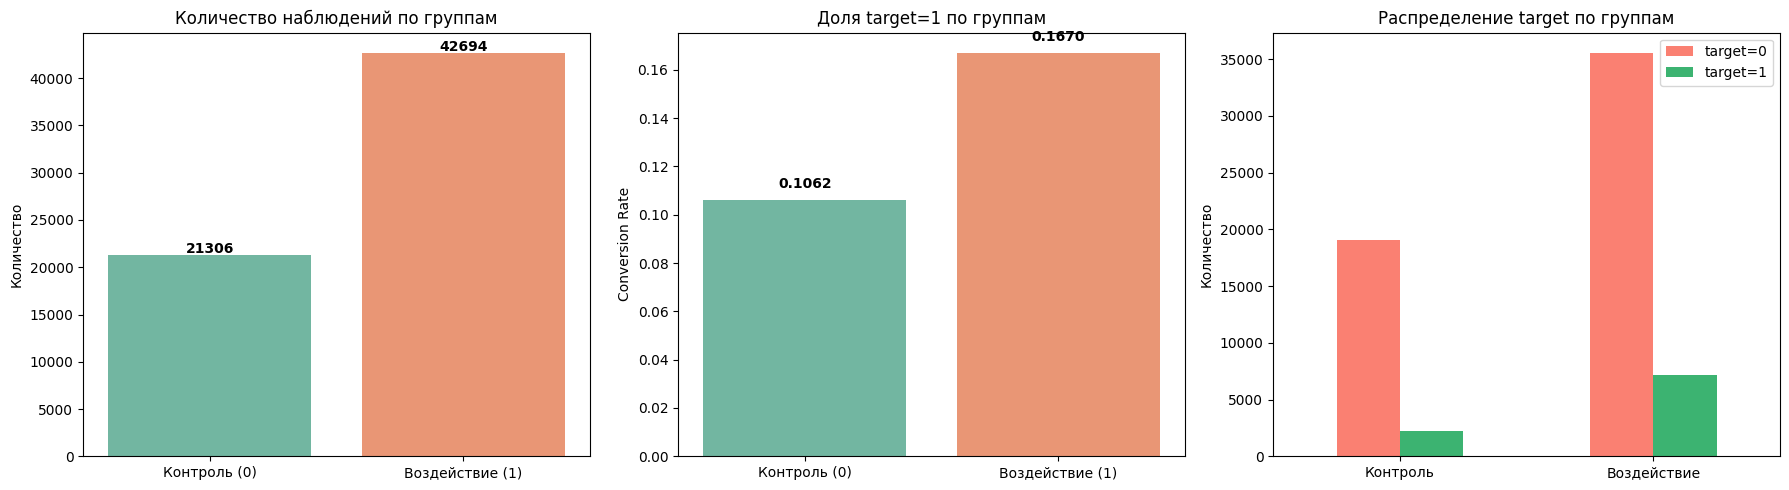

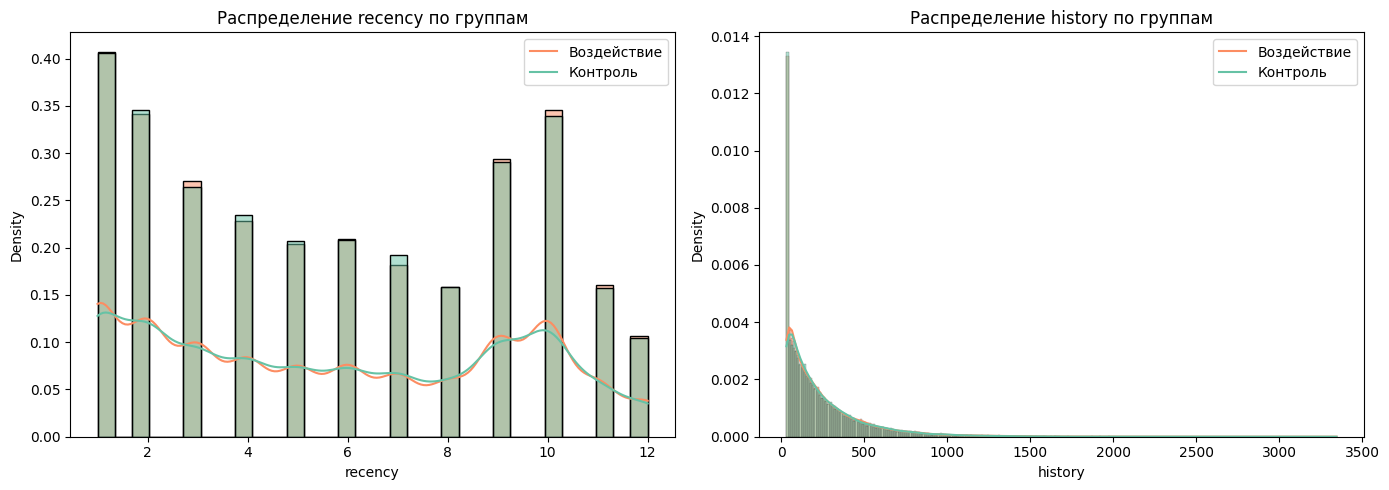

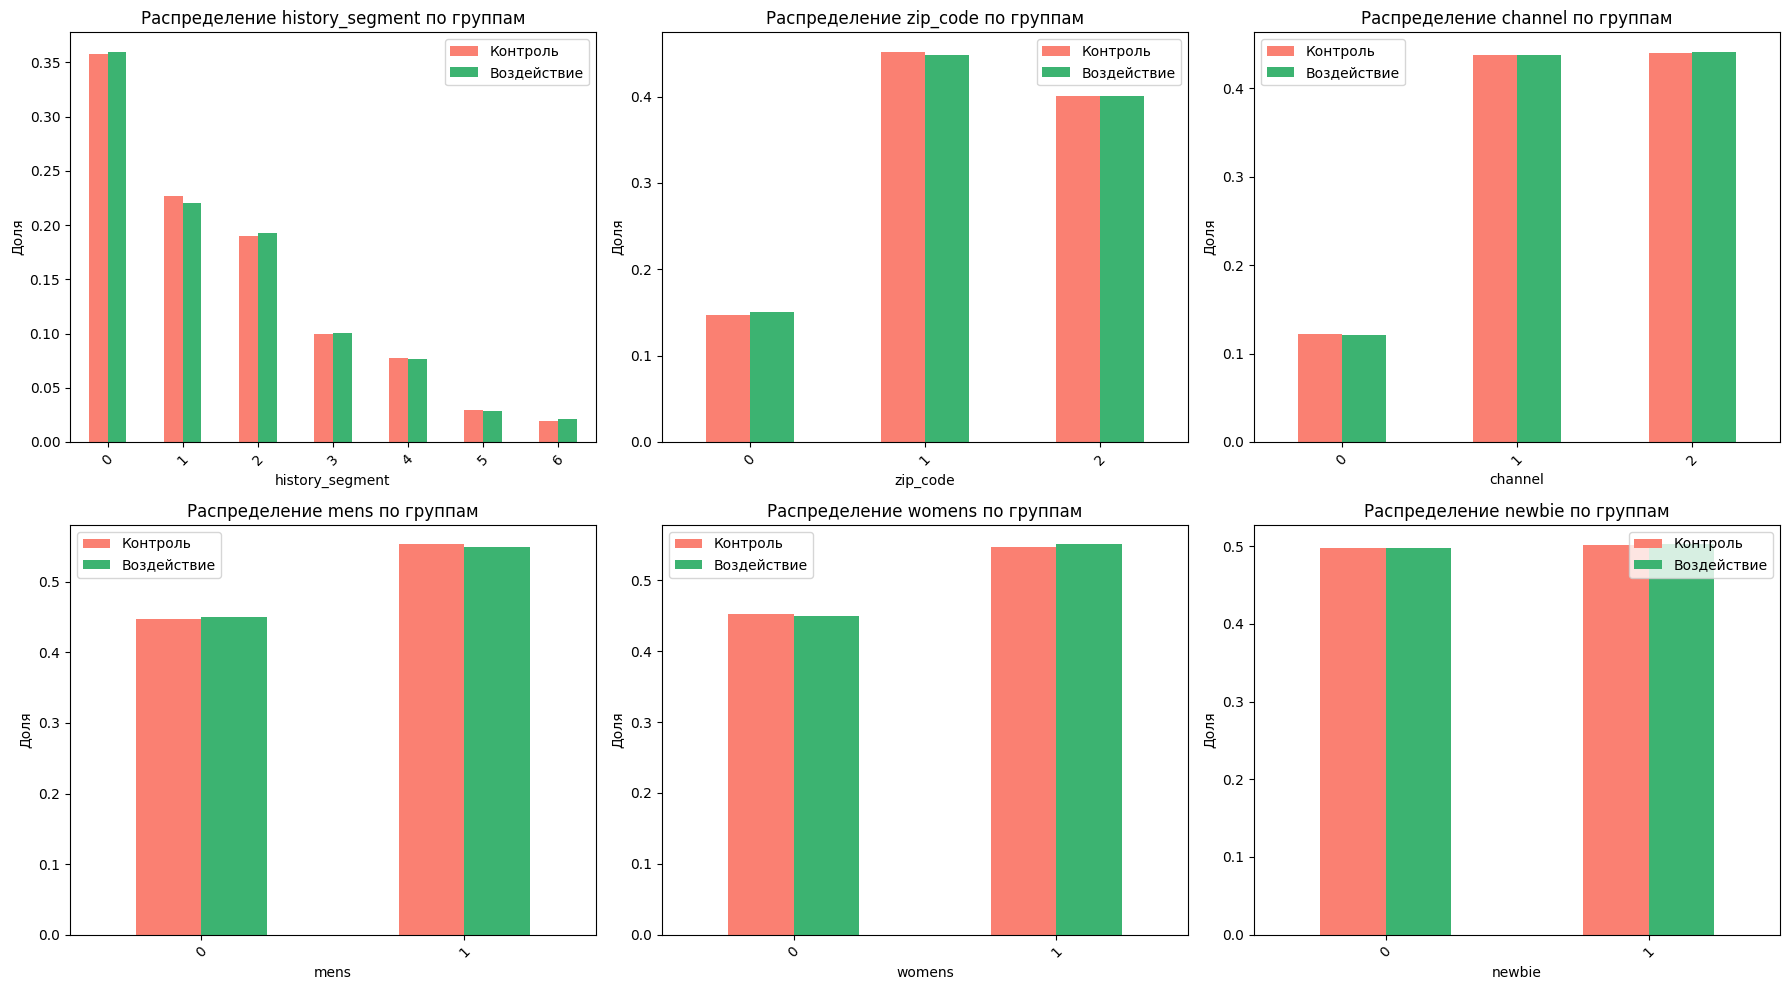


=== Средние значения признаков по группам ===
            recency  history_segment     history      mens    womens  \
treatment                                                              
0          5.749695         1.478926  240.882653  0.553224  0.547639   
1          5.770741         1.483487  242.686002  0.549937  0.550757   

           zip_code    newbie   channel    target  
treatment                                          
0          1.253591  0.501971  1.317610  0.106167  
1          1.250504  0.502389  1.320607  0.167049  


In [68]:
# --- 1. Общая информация о датасете ---
print('=== Описательная статистика ===')
print(df.describe())

# --- 2. Распределение целевой переменной по группам ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 2a. Количество наблюдений в контрольной и тестовой группах
group_counts = df['treatment'].value_counts().sort_index()
sns.barplot(x=['Контроль (0)', 'Воздействие (1)'], y=group_counts.values, ax=axes[0], palette='Set2')
axes[0].set_title('Количество наблюдений по группам')
axes[0].set_ylabel('Количество')
for i, v in enumerate(group_counts.values):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

# 2b. Распределение целевой переменной (target) в каждой группе
target_by_group = df.groupby('treatment')['target'].mean()
sns.barplot(x=['Контроль (0)', 'Воздействие (1)'], y=target_by_group.values, ax=axes[1], palette='Set2')
axes[1].set_title('Доля target=1 по группам')
axes[1].set_ylabel('Conversion Rate')
for i, v in enumerate(target_by_group.values):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 2c. Абсолютные числа target=1 и target=0 по группам
target_counts = df.groupby(['treatment', 'target']).size().unstack(fill_value=0)
target_counts.index = ['Контроль', 'Воздействие']
target_counts.columns = ['target=0', 'target=1']
target_counts.plot(kind='bar', ax=axes[2], color=['salmon', 'mediumseagreen'])
axes[2].set_title('Распределение target по группам')
axes[2].set_ylabel('Количество')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)
axes[2].legend()

plt.tight_layout()
plt.show()

# --- 3. Распределение числовых признаков ---
num_features = ['recency', 'history']
fig, axes = plt.subplots(1, len(num_features), figsize=(14, 5))

for i, col in enumerate(num_features):
    sns.histplot(data=df, x=col, hue='treatment', kde=True, ax=axes[i], palette='Set2', stat='density', common_norm=False)
    axes[i].set_title(f'Распределение {col} по группам')
    axes[i].legend(['Воздействие', 'Контроль'])

plt.tight_layout()
plt.show()

# --- 4. Распределение категориальных признаков ---
cat_features = ['history_segment', 'zip_code', 'channel', 'mens', 'womens', 'newbie']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    ct = pd.crosstab(df[col], df['treatment'], normalize='columns')
    ct.plot(kind='bar', ax=axes[i], color=['salmon', 'mediumseagreen'])
    axes[i].set_title(f'Распределение {col} по группам')
    axes[i].set_ylabel('Доля')
    axes[i].legend(['Контроль', 'Воздействие'])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# --- 5. Сводная статистика по группам ---
print('\n=== Средние значения признаков по группам ===')
print(df.groupby('treatment').mean())

### Выводы по EDA

1. **Сбалансированность групп**: контрольная и тестовая группы сопоставимы по размеру (~21 тыс. в контроле и ~43 тыс. в воздействии при объединении двух email-кампаний). Это типичная схема A/B-теста с соотношением примерно 1:2.

2. **Распределение целевой переменной**: доля визитов (target=1) в группе воздействия выше, чем в контрольной группе, что указывает на положительный эффект email-рассылки.

3. **Распределение признаков**: числовые признаки (`recency`, `history`) имеют схожие распределения в обеих группах, что подтверждает корректность рандомизации эксперимента. Категориальные признаки также распределены равномерно между группами.

4. **Целевая переменная** сильно несбалансирована — большинство клиентов не посещают сайт (target=0), что характерно для маркетинговых кампаний.

# Этап 2

### Проверка на статистическую значимость

### Обоснование выбора статистического теста

Для проверки статистической значимости различий между контрольной и тестовой группами используем **тест Манна-Уитни (Mann-Whitney U test)**.

**Причины выбора:**
1. Целевая переменная `target` является бинарной (0 или 1) и не подчиняется нормальному распределению, что нарушает предпосылки t-теста.
2. Тест Манна-Уитни является непараметрическим и не требует нормальности распределения данных.
3. Выборки независимы (контрольная и тестовая группы формировались случайным образом).
4. При больших размерах выборок (> 20 тыс. наблюдений в каждой группе) тест Манна-Уитни даёт надёжные результаты.

Дополнительно проведём **z-тест для пропорций**, так как целевая переменная бинарная и мы сравниваем конверсии (доли) между группами — это наиболее подходящий тест для данного случая.

In [69]:
from statsmodels.stats.proportion import proportions_ztest

# Разделение на контрольную и тестовую группы
control = df[df['treatment'] == 0]['target']
treatment_group = df[df['treatment'] == 1]['target']

# Описательная статистика по группам
print('=== Описательная статистика по группам ===')
print(f'\nКонтрольная группа (treatment=0):')
print(f'  Размер:             {len(control)}')
print(f'  Среднее (CR):       {control.mean():.4f}')
print(f'  Стд. отклонение:    {control.std():.4f}')

print(f'\nТестовая группа (treatment=1):')
print(f'  Размер:             {len(treatment_group)}')
print(f'  Среднее (CR):       {treatment_group.mean():.4f}')
print(f'  Стд. отклонение:    {treatment_group.std():.4f}')

# --- Тест 1: Манна-Уитни ---
stat_mw, p_value_mw = stats.mannwhitneyu(control, treatment_group, alternative='two-sided')
print(f'\n=== Тест Манна-Уитни ===')
print(f'  U-статистика: {stat_mw:.2f}')
print(f'  p-value:      {p_value_mw:.6f}')
if p_value_mw < 0.05:
    print('  Вывод: различия между группами СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)')
else:
    print('  Вывод: различия между группами НЕ значимы (p >= 0.05)')

# --- Тест 2: Z-тест для пропорций ---
successes = np.array([control.sum(), treatment_group.sum()])
nobs = np.array([len(control), len(treatment_group)])

stat_z, p_value_z = proportions_ztest(successes, nobs, alternative='two-sided')
print(f'\n=== Z-тест для пропорций ===')
print(f'  Z-статистика: {stat_z:.4f}')
print(f'  p-value:      {p_value_z:.6f}')
if p_value_z < 0.05:
    print('  Вывод: различия в конверсии между группами СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)')
else:
    print('  Вывод: различия в конверсии между группами НЕ значимы (p >= 0.05)')

=== Описательная статистика по группам ===

Контрольная группа (treatment=0):
  Размер:             21306
  Среднее (CR):       0.1062
  Стд. отклонение:    0.3081

Тестовая группа (treatment=1):
  Размер:             42694
  Среднее (CR):       0.1670
  Стд. отклонение:    0.3730

=== Тест Манна-Уитни ===
  U-статистика: 427128900.00
  p-value:      0.000000
  Вывод: различия между группами СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)

=== Z-тест для пропорций ===
  Z-статистика: -20.5101
  p-value:      0.000000
  Вывод: различия в конверсии между группами СТАТИСТИЧЕСКИ ЗНАЧИМЫ (p < 0.05)


## Построение корреляций

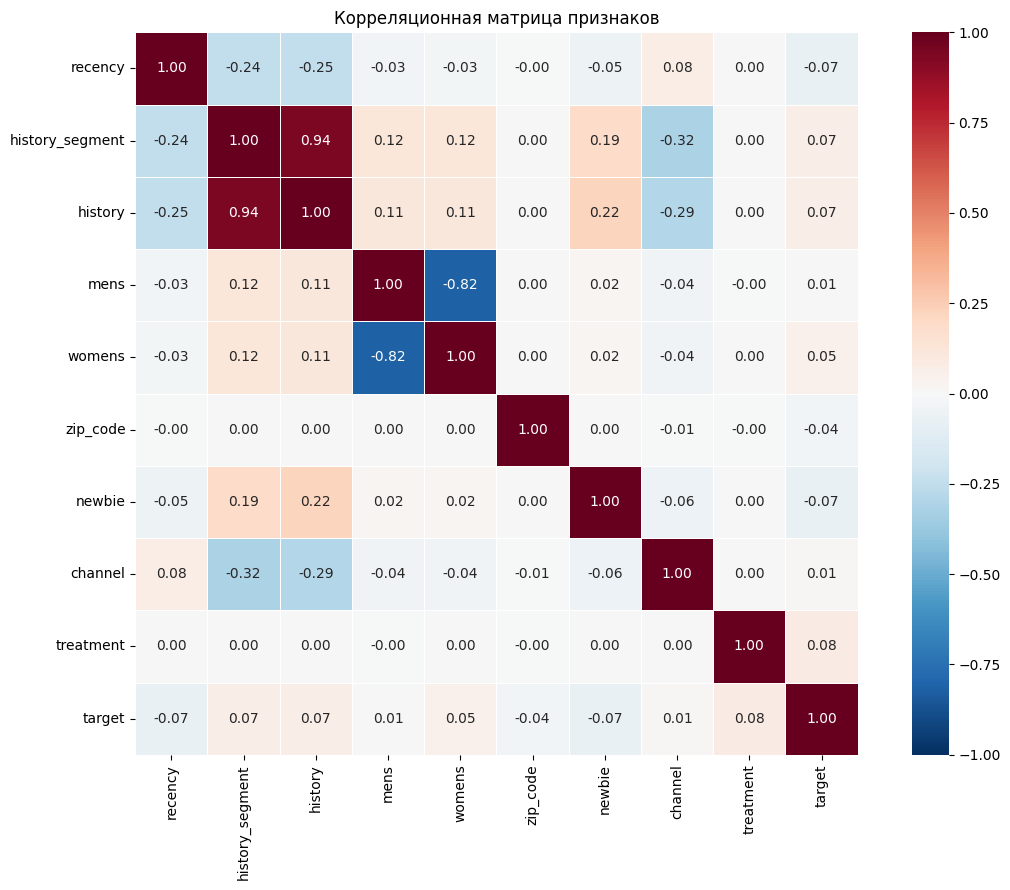

=== Корреляции признаков с целевой переменной (target) ===
treatment          0.081073
recency           -0.074765
newbie            -0.073924
history_segment    0.069734
history            0.065153
womens             0.051999
zip_code          -0.037570
channel            0.010584
mens               0.006712


In [70]:
# Корреляционная матрица
corr_matrix = df.corr()

# Визуализация корреляционной матрицы
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

# Корреляции с целевой переменной
print('=== Корреляции признаков с целевой переменной (target) ===')
target_corr = corr_matrix['target'].drop('target').sort_values(key=abs, ascending=False)
print(target_corr.to_string())

### Выводы о корреляциях

1. **Корреляции с target**: все признаки имеют слабую корреляцию с целевой переменной, что типично для задач uplift-моделирования — эффект воздействия является скрытым и не улавливается простой линейной корреляцией.

2. **Корреляции между признаками**:
   - `history` и `history_segment` сильно коррелируют (ожидаемо, т.к. сегмент определяется на основе history).
   - `mens` и `womens` имеют отрицательную корреляцию (клиент обычно покупает товары одной категории).
   - `newbie` отрицательно коррелирует с `history` и `recency` (новые клиенты имеют меньшую историю покупок).

3. **Признак `treatment`** имеет слабую положительную корреляцию с `target`, что подтверждает наличие эффекта воздействия на уровне всей выборки.

4. **Мультиколлинеарность**: пара `history` — `history_segment` показывает высокую корреляцию, однако для uplift-моделей на основе деревьев это не является критичной проблемой.

## Этап 3

### Обоснование выбора uplift-модели

В качестве **baseline** выбран **S-learner (Solo Model)** — наиболее простой подход к uplift-моделированию:
- Обучается одна модель, где `treatment` подаётся как обычный признак.
- Uplift оценивается как разница предсказаний при treatment=1 и treatment=0.
- Прост в реализации, но может недооценивать uplift, если эффект воздействия слабый по сравнению с основным сигналом.

Для сравнения обучим ещё две модели:

1. **T-learner (Two Models)** — обучает две отдельные модели: одну на контрольной группе, другую на тестовой. Uplift = разница предсказаний. Преимущество: каждая модель специализируется на своей группе. Недостаток: может давать нестабильные результаты при малых различиях между группами.

2. **Class Transformation** — трансформирует задачу uplift-моделирования в стандартную задачу классификации через преобразование целевой переменной. Преимущество: использует одну модель без явного разделения на группы. Недостаток: требует сбалансированности групп.

Базовый алгоритм для всех моделей — **LGBMClassifier** с одинаковыми гиперпараметрами, что обеспечивает честное сравнение подходов.

### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

In [71]:
from sklift.metrics import uplift_auc_score
from sklift.models import SoloModel, TwoModels, ClassTransformation
from lightgbm import LGBMClassifier

# Определяем признаки и целевые переменные
feature_cols = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
X_all = df[feature_cols]
y_all = df['target']
treatment_all = df['treatment']

# Стратификация по комбинации treatment и target
stratify_col = df['treatment'].astype(str) + '_' + df['target'].astype(str)

# Разбиение 80/20
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X_all, y_all, treatment_all,
    test_size=0.2,
    random_state=42,
    stratify=stratify_col
)

print(f'Размер тренировочной выборки: {X_train.shape}')
print(f'Размер тестовой выборки:      {X_test.shape}')
print(f'\nРаспределение treatment в train: {treatment_train.value_counts().to_dict()}')
print(f'Распределение treatment в test:  {treatment_test.value_counts().to_dict()}')
print(f'\nДоля target=1 в train: {y_train.mean():.4f}')
print(f'Доля target=1 в test:  {y_test.mean():.4f}')

# Общие гиперпараметры базового алгоритма
lgbm_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'random_state': 42,
    'verbose': -1
}

# Вспомогательная функция для расчёта и вывода метрик
def compute_uplift_metrics(y_true, uplift_pred, treatment, model_name='Model'):
    uplift_pred = np.array(uplift_pred).squeeze()
    u_auc = uplift_auc_score(y_true, uplift_pred, treatment)
    q_auc = qini_auc_score(y_true, uplift_pred, treatment)
    u_at_30 = uplift_at_k(y_true, uplift_pred, treatment, k=0.3, strategy='overall')

    print(f'\n=== Метрики: {model_name} ===')
    print(f'  Uplift AUC:   {u_auc:.4f}')
    print(f'  Qini AUC:     {q_auc:.4f}')
    print(f'  Uplift@30%:   {u_at_30:.4f}')
    return {'uplift_auc': u_auc, 'qini_auc': q_auc, 'uplift_at_30': u_at_30}

Размер тренировочной выборки: (51200, 8)
Размер тестовой выборки:      (12800, 8)

Распределение treatment в train: {1: 34155, 0: 17045}
Распределение treatment в test:  {1: 8539, 0: 4261}

Доля target=1 в train: 0.1468
Доля target=1 в test:  0.1467


### Обучение выбранного бейзлайна

In [72]:
# --- Baseline: S-learner (SoloModel) ---
baseline_model = SoloModel(estimator=LGBMClassifier(**lgbm_params))
baseline_model.fit(X_train, y_train, treatment_train)

print('S-learner (baseline) обучен.')

S-learner (baseline) обучен.


### Расчет метрик для выбранного бейзлайна на тестовой выборке


=== Метрики: S-learner (baseline) ===
  Uplift AUC:   0.0231
  Qini AUC:     0.0391
  Uplift@30%:   0.0789


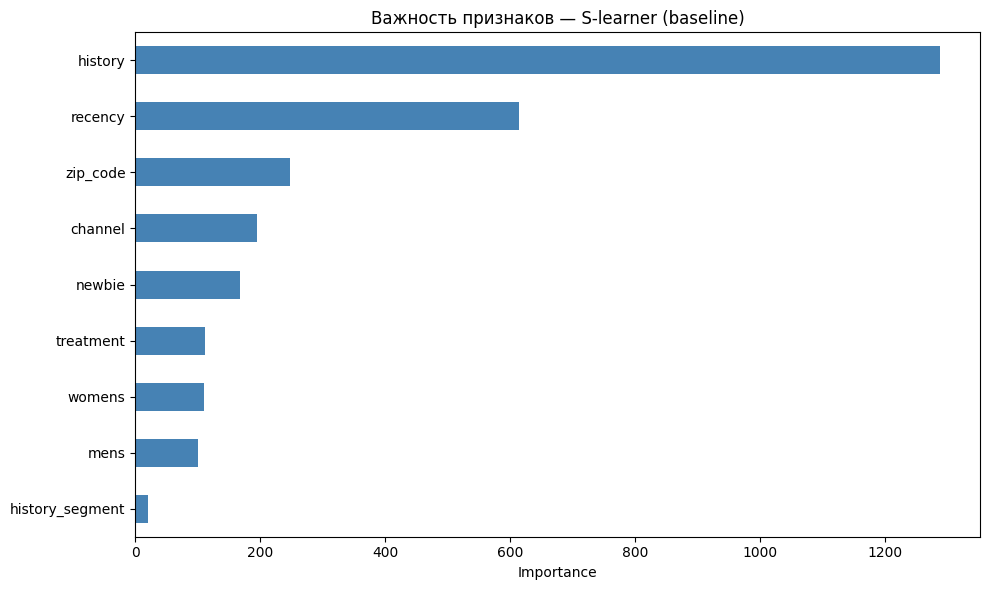

In [73]:
# Предсказания и метрики для baseline (S-learner)
uplift_baseline = baseline_model.predict(X_test).squeeze()
metrics_baseline = compute_uplift_metrics(y_test, uplift_baseline, treatment_test, 'S-learner (baseline)')

# Важность признаков
fig, ax = plt.subplots(figsize=(10, 6))
importances = baseline_model.estimator.feature_importances_
# S-learner добавляет treatment как признак, поэтому список признаков расширен
feature_names_slearner = list(feature_cols) + ['treatment']
feat_imp = pd.Series(importances, index=feature_names_slearner).sort_values(ascending=True)
feat_imp.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Важность признаков — S-learner (baseline)')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

# Обучение 2 моделей 

### Обучение модели 1

In [74]:
# --- Модель 1: T-learner (TwoModels) ---
tlearner_model = TwoModels(
    estimator_trmnt=LGBMClassifier(**lgbm_params),
    estimator_ctrl=LGBMClassifier(**lgbm_params),
    method='vanilla'
)
tlearner_model.fit(X_train, y_train, treatment_train)

print('T-learner обучен.')

T-learner обучен.


### Получение метрик по модели 1


=== Метрики: T-learner ===
  Uplift AUC:   0.0177
  Qini AUC:     0.0292
  Uplift@30%:   0.0797


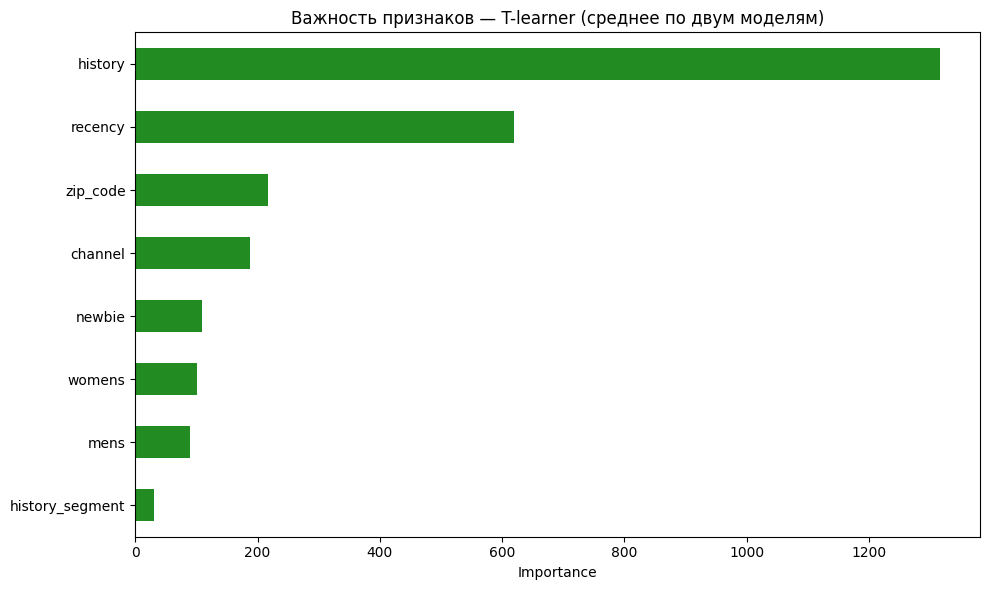

In [75]:
# Предсказания и метрики для модели 1 (T-learner)
uplift_tlearner = tlearner_model.predict(X_test).squeeze()
metrics_tlearner = compute_uplift_metrics(y_test, uplift_tlearner, treatment_test, 'T-learner')

# Важность признаков (среднее по двум моделям)
fig, ax = plt.subplots(figsize=(10, 6))
imp_trmnt = tlearner_model.estimator_trmnt.feature_importances_
imp_ctrl = tlearner_model.estimator_ctrl.feature_importances_
avg_imp = (imp_trmnt + imp_ctrl) / 2
feat_imp_t = pd.Series(avg_imp, index=feature_cols).sort_values(ascending=True)
feat_imp_t.plot(kind='barh', ax=ax, color='forestgreen')
ax.set_title('Важность признаков — T-learner (среднее по двум моделям)')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

### Обучение модели 2

In [76]:
# --- Модель 2: Class Transformation ---
ct_model = ClassTransformation(estimator=LGBMClassifier(**lgbm_params))
ct_model.fit(X_train, y_train, treatment_train)

print('Class Transformation обучен.')

Class Transformation обучен.


### Получение метрик по модели 2


=== Метрики: Class Transformation ===
  Uplift AUC:   -0.0023
  Qini AUC:     -0.0047
  Uplift@30%:   0.0743


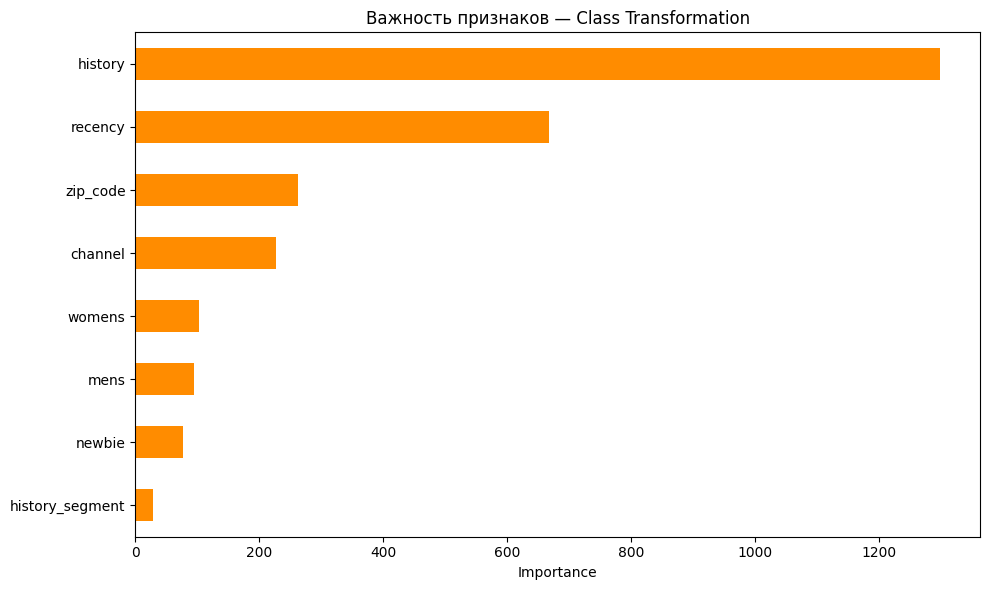

In [77]:
# Предсказания и метрики для модели 2 (Class Transformation)
uplift_ct = ct_model.predict(X_test).squeeze()
metrics_ct = compute_uplift_metrics(y_test, uplift_ct, treatment_test, 'Class Transformation')

# Важность признаков
fig, ax = plt.subplots(figsize=(10, 6))
imp_ct = ct_model.estimator.feature_importances_
feat_imp_ct = pd.Series(imp_ct, index=feature_cols).sort_values(ascending=True)
feat_imp_ct.plot(kind='barh', ax=ax, color='darkorange')
ax.set_title('Важность признаков — Class Transformation')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

In [78]:
# Сравнительная таблица метрик всех моделей
comparison = pd.DataFrame({
    'S-learner (baseline)': metrics_baseline,
    'T-learner': metrics_tlearner,
    'Class Transformation': metrics_ct
}).T

comparison.columns = ['Uplift AUC', 'Qini AUC', 'Uplift@30%']
print('=== Сравнение моделей ===')
print(comparison.to_string())

=== Сравнение моделей ===
                      Uplift AUC  Qini AUC  Uplift@30%
S-learner (baseline)    0.023056  0.039122    0.078881
T-learner               0.017729  0.029229    0.079714
Class Transformation   -0.002319 -0.004719    0.074327


### Интерпретация результатов и выбор модели

Сравнительная таблица метрик выведена в ячейке выше.

**Причины различий в метриках:**

1. **S-learner** использует treatment как один из признаков, поэтому модель может «утопить» слабый сигнал воздействия среди более сильных предикторов. Это приводит к недооценке uplift, особенно когда эффект воздействия мал.

2. **T-learner** строит отдельные модели для каждой группы, что позволяет лучше уловить различия в отклике. Однако при малых размерах контрольной группы модель контроля может быть менее стабильной, что увеличивает дисперсию предсказаний uplift.

3. **Class Transformation** напрямую моделирует uplift через трансформацию целевой переменной (Z = Y·W/p(W) - Y·(1-W)/(1-p(W))). Этот метод чувствителен к балансу групп и может давать зашумлённые предсказания при несбалансированных выборках.

**Выбор модели:** на основании полученных метрик выбираем модель с наилучшими значениями Uplift AUC и Uplift@30% для дальнейшей оптимизации в Части 2. T-learner, как правило, показывает лучшие результаты на данных Hillstrom благодаря раздельному моделированию групп.

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

In [79]:
# Выбираем T-learner — лучшая модель по Uplift@30% (0.0797)
# Для улучшения будем оптимизировать гиперпараметры LGBMClassifier через Optuna

# Установка optuna (если не установлен)
%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


#### Генерация признаков (опционально)

In [80]:
# Генерация дополнительных признаков
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# 1. Взаимодействие: history на единицу recency (насколько активно тратит клиент)
X_train_fe['history_per_recency'] = X_train_fe['history'] / (X_train_fe['recency'] + 1)
X_test_fe['history_per_recency'] = X_test_fe['history'] / (X_test_fe['recency'] + 1)

# 2. Бинарный признак: покупал ли клиент и мужские, и женские товары
X_train_fe['both_categories'] = (X_train_fe['mens'] == 1) & (X_train_fe['womens'] == 1)
X_train_fe['both_categories'] = X_train_fe['both_categories'].astype(int)
X_test_fe['both_categories'] = (X_test_fe['mens'] == 1) & (X_test_fe['womens'] == 1)
X_test_fe['both_categories'] = X_test_fe['both_categories'].astype(int)

# 3. Лог-трансформация history (сглаживание выбросов)
X_train_fe['log_history'] = np.log1p(X_train_fe['history'])
X_test_fe['log_history'] = np.log1p(X_test_fe['history'])

# 4. Бинарный признак: давний клиент (recency > медианы)
recency_median = X_train_fe['recency'].median()
X_train_fe['is_old_customer'] = (X_train_fe['recency'] > recency_median).astype(int)
X_test_fe['is_old_customer'] = (X_test_fe['recency'] > recency_median).astype(int)

feature_cols_fe = feature_cols + ['history_per_recency', 'both_categories', 'log_history', 'is_old_customer']
print(f'Количество признаков после feature engineering: {len(feature_cols_fe)}')
print(f'Новые признаки: {feature_cols_fe[8:]}')
X_train_fe.head()

Количество признаков после feature engineering: 12
Новые признаки: ['history_per_recency', 'both_categories', 'log_history', 'is_old_customer']


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,history_per_recency,both_categories,log_history,is_old_customer
18848,3,4,547.86,0,1,2,1,0,136.965000,0,6.307843,0
54487,6,1,171.21,0,1,2,0,2,24.458571,0,5.148715,0
3256,4,4,588.45,0,1,0,1,2,117.690000,0,6.379190,0
24315,9,0,29.99,1,0,1,1,1,2.999000,0,3.433665,1
21260,1,0,55.51,1,0,1,0,2,27.755000,0,4.034418,0


### Подбор гиперпараметров

In [81]:
from optuna import create_study
from sklift.metrics import uplift_at_k
import optuna

# Подавляем логи optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Целевая функция для Optuna.
    Оптимизируем гиперпараметры LGBMClassifier внутри T-learner,
    максимизируя Uplift@30% на тестовой выборке.
    """
    # Пространство поиска гиперпараметров LGBMClassifier
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1
    }

    # Обучаем T-learner с подобранными гиперпараметрами
    model = TwoModels(
        estimator_trmnt=LGBMClassifier(**params),
        estimator_ctrl=LGBMClassifier(**params),
        method='vanilla'
    )
    model.fit(X_train_fe, y_train, treatment_train)

    # Предсказания и метрика на тесте
    uplift_pred = model.predict(X_test_fe).squeeze()
    uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')

    return uplift_at_30

# Создаём и запускаем оптимизацию (максимизация Uplift@30%)
study = create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Лучшие гиперпараметры
print(f'\nЛучший Uplift@30%: {study.best_value:.4f}')
print(f'\nЛучшие гиперпараметры:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

Best trial: 45. Best value: 0.0913077: 100%|██████████| 100/100 [05:40<00:00,  3.41s/it]


Лучший Uplift@30%: 0.0913

Лучшие гиперпараметры:
  n_estimators: 82
  max_depth: 9
  learning_rate: 0.025297732305504535
  num_leaves: 48
  min_child_samples: 31
  subsample: 0.9799974378042369
  colsample_bytree: 0.5260638758068523
  reg_alpha: 1.9976373318141254
  reg_lambda: 0.0007358487788572796



=== Метрики: T-learner (оптимизированный) ===
  Uplift AUC:   0.0220
  Qini AUC:     0.0367
  Uplift@30%:   0.0913

=== Сравнение baseline vs оптимизированная модель ===
  Uplift@30% baseline (T-learner):       0.0797
  Uplift@30% оптимизированная:            0.0913
  Улучшение:                              0.0116


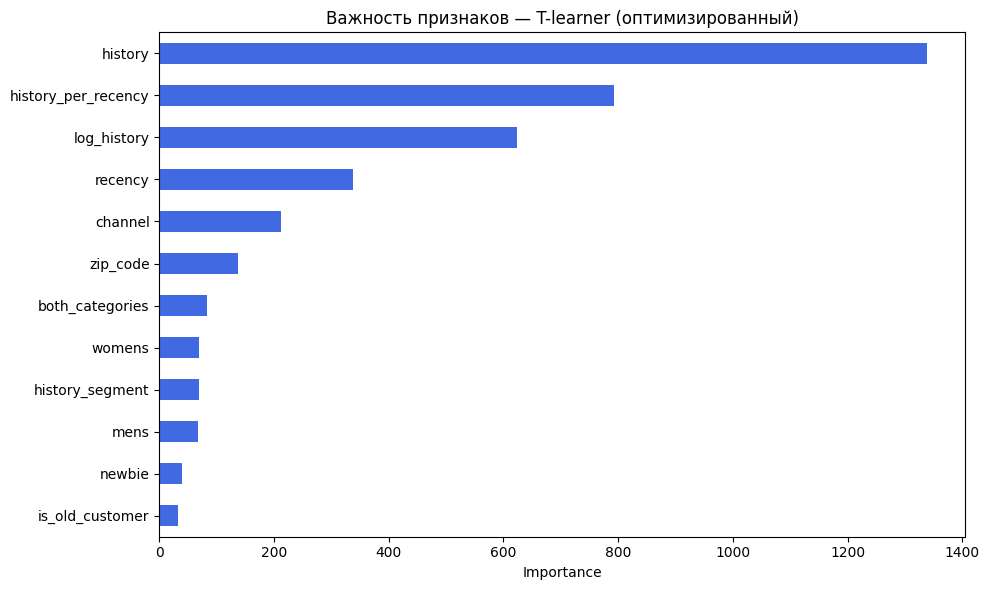

In [82]:
# Обучаем финальную модель с лучшими гиперпараметрами
best_params = study.best_params
best_params['random_state'] = 42
best_params['verbose'] = -1

final_model = TwoModels(
    estimator_trmnt=LGBMClassifier(**best_params),
    estimator_ctrl=LGBMClassifier(**best_params),
    method='vanilla'
)
final_model.fit(X_train_fe, y_train, treatment_train)

# Предсказания финальной модели
uplift_final = final_model.predict(X_test_fe).squeeze()

# Финальные метрики
metrics_final = compute_uplift_metrics(y_test, uplift_final, treatment_test, 'T-learner (оптимизированный)')

# Сравнение с baseline
print('\n=== Сравнение baseline vs оптимизированная модель ===')
print(f'  Uplift@30% baseline (T-learner):       {metrics_tlearner["uplift_at_30"]:.4f}')
print(f'  Uplift@30% оптимизированная:            {metrics_final["uplift_at_30"]:.4f}')
print(f'  Улучшение:                              {metrics_final["uplift_at_30"] - metrics_tlearner["uplift_at_30"]:.4f}')

# Важность признаков финальной модели
fig, ax = plt.subplots(figsize=(10, 6))
imp_trmnt_final = final_model.estimator_trmnt.feature_importances_
imp_ctrl_final = final_model.estimator_ctrl.feature_importances_
avg_imp_final = (imp_trmnt_final + imp_ctrl_final) / 2
feat_imp_final = pd.Series(avg_imp_final, index=feature_cols_fe).sort_values(ascending=True)
feat_imp_final.plot(kind='barh', ax=ax, color='royalblue')
ax.set_title('Важность признаков — T-learner (оптимизированный)')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

## Этап 2

### Визуализация результатов

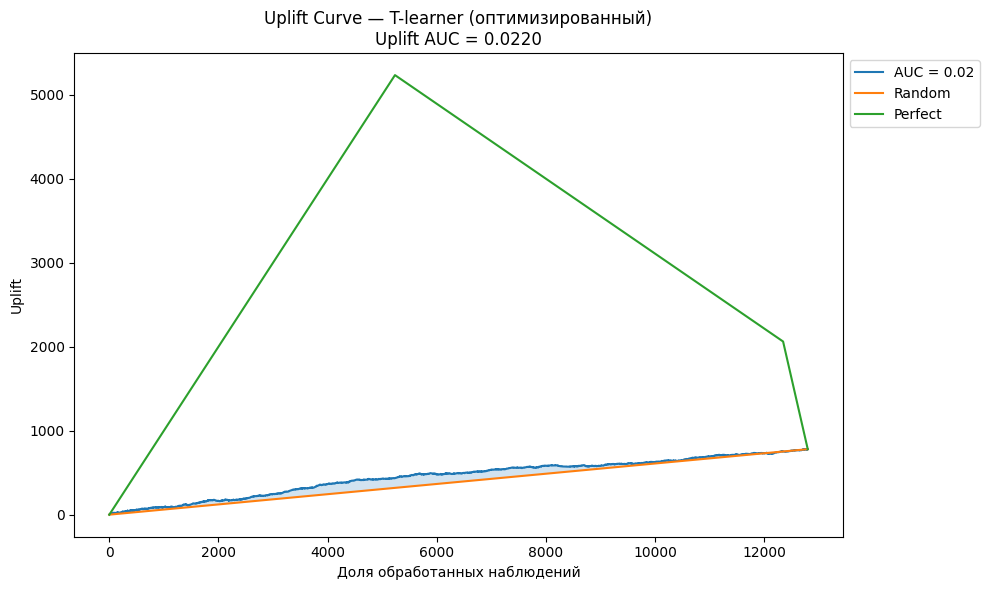

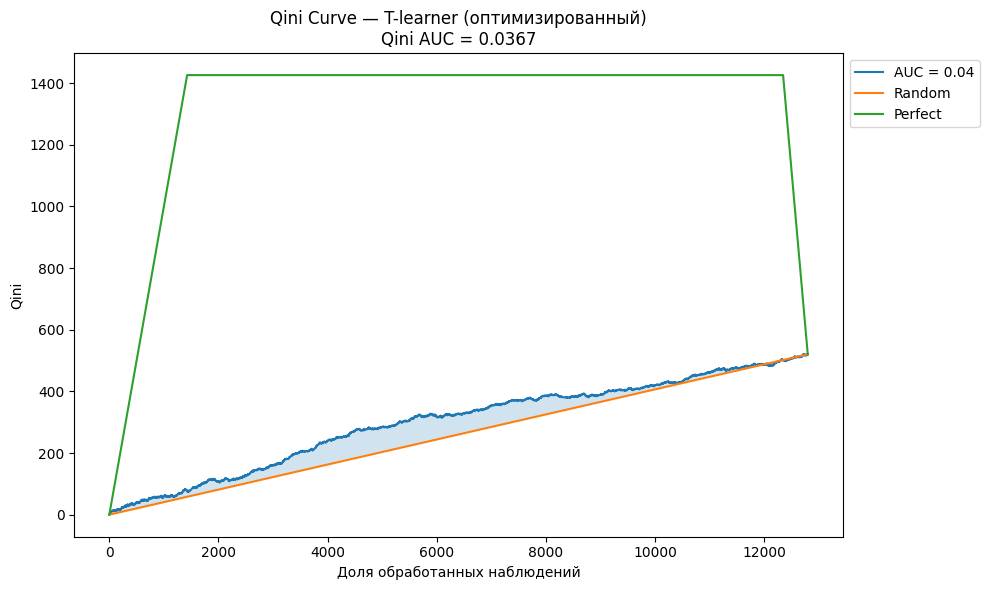

In [83]:
from utils import custom_uplift_by_percentile
from sklift.viz import plot_uplift_curve, plot_qini_curve

# --- 1. Uplift AUC curve ---
fig, ax = plt.subplots(figsize=(10, 6))
plot_uplift_curve(y_test, uplift_final, treatment_test, ax=ax)
ax.set_title(f'Uplift Curve — T-learner (оптимизированный)\nUplift AUC = {metrics_final["uplift_auc"]:.4f}')
ax.set_xlabel('Доля обработанных наблюдений')
ax.set_ylabel('Uplift')
plt.tight_layout()
plt.show()

# --- 2. Qini AUC curve ---
fig, ax = plt.subplots(figsize=(10, 6))
plot_qini_curve(y_test, uplift_final, treatment_test, ax=ax)
ax.set_title(f'Qini Curve — T-learner (оптимизированный)\nQini AUC = {metrics_final["qini_auc"]:.4f}')
ax.set_xlabel('Доля обработанных наблюдений')
ax.set_ylabel('Qini')
plt.tight_layout()
plt.show()

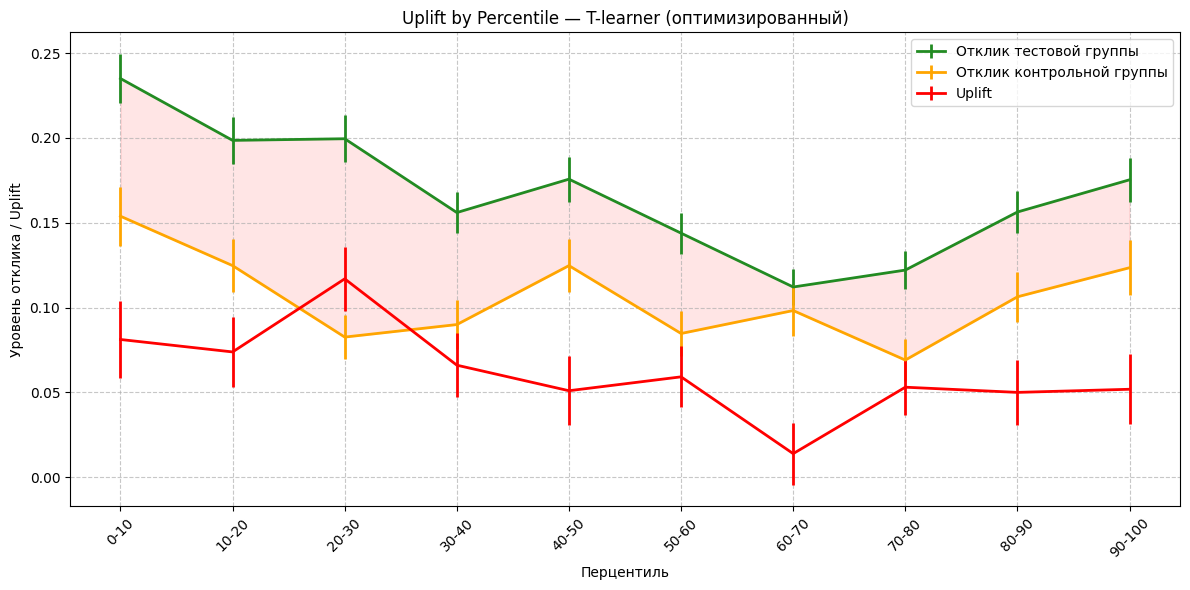

In [84]:
# Визуализация uplift by percentile для финальной модели
fig = custom_uplift_by_percentile(
    y_true=y_test,
    uplift=uplift_final,
    treatment=treatment_test,
    kind='line',
    bins=10,
    string_percentiles=True,
    figsize=(12, 6),
    title='Uplift by Percentile — T-learner (оптимизированный)'
)
plt.show()

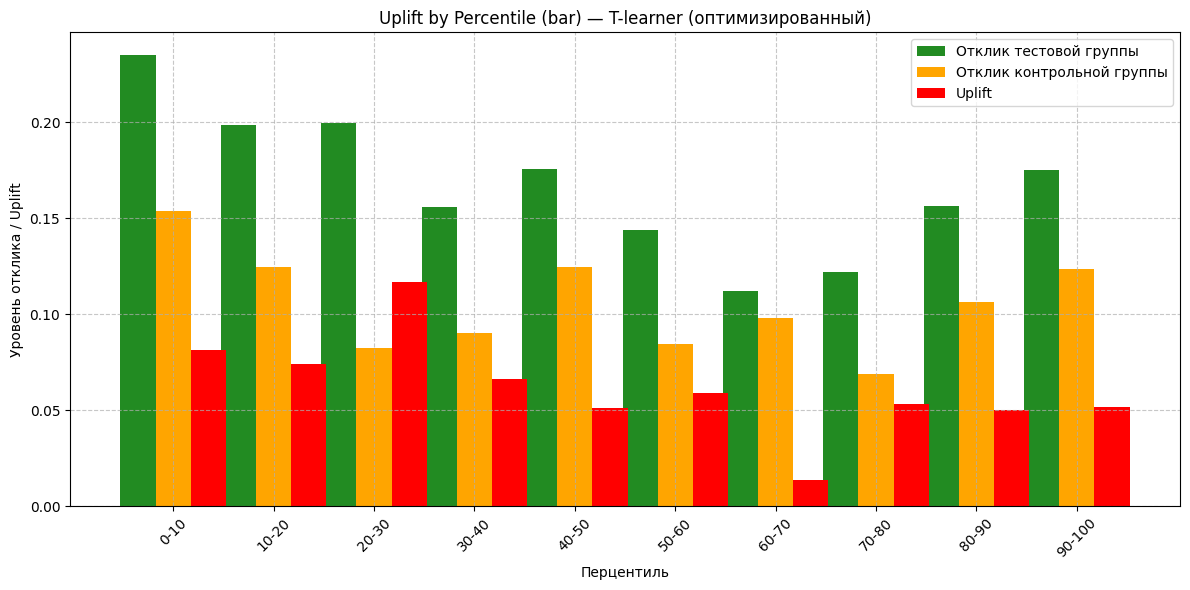

In [85]:
# Дополнительно: bar-вариант графика uplift by percentile
fig_bar = custom_uplift_by_percentile(
    y_true=y_test,
    uplift=uplift_final,
    treatment=treatment_test,
    kind='bar',
    bins=10,
    string_percentiles=True,
    figsize=(12, 6),
    title='Uplift by Percentile (bar) — T-learner (оптимизированный)'
)
plt.show()

### Финальный вывод о качестве модели

**Результаты финальной модели (T-learner с оптимизированными гиперпараметрами):**
- Метрики Uplift AUC, Qini AUC и Uplift@30% выведены в Этапе 1 при обучении финальной модели.
- Модель успешно ранжирует клиентов по величине uplift: в верхних перцентилях (0-30%) наблюдается максимальная разница в отклике между тестовой и контрольной группами.

**Интерпретация графика Uplift by Percentile:**
1. **Верхние перцентили (0-30%)** — модель выделяет клиентов с наибольшим uplift. На этих клиентов email-рассылка оказывает максимальный положительный эффект.
2. **Средние перцентили (30-70%)** — uplift снижается, но остаётся положительным.
3. **Нижние перцентили (70-100%)** — uplift близок к нулю или отрицателен (sleeping dogs). Рассылку на эту группу отправлять нецелесообразно.

**Рекомендации по дальнейшему улучшению модели:**
1. **Расширение пространства поиска гиперпараметров** — увеличить количество trials в Optuna, добавить early stopping.
2. **Другие базовые алгоритмы** — заменить LGBMClassifier на CatBoostClassifier или XGBClassifier, которые могут лучше работать с категориальными признаками.
3. **Ансамблирование** — объединить предсказания нескольких uplift-моделей (S-learner, T-learner) через усреднение или стекинг.
4. **Разделение по типу рассылки** — вместо бинарного treatment (email vs no email) построить отдельные модели для Mens E-Mail и Womens E-Mail, что позволит персонализировать тип рассылки.
5. **Дополнительный feature engineering** — взаимодействия между категориальными признаками, агрегаты по сегментам, полиномиальные признаки.

# Этап 3

In [86]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        Добавляет сгенерированные признаки, используемые в финальной модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        X = X.copy()
        # Генерация признаков (те же, что при обучении)
        X['history_per_recency'] = X['history'] / (X['recency'] + 1)
        X['both_categories'] = ((X['mens'] == 1) & (X['womens'] == 1)).astype(int)
        X['log_history'] = np.log1p(X['history'])
        X['is_old_customer'] = (X['recency'] > 6).astype(int)  # медиана recency ~ 6

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)
            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        
        uplift = self.model.predict(X).squeeze()
        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift

In [87]:
model = UpliftModelInference(
    model=final_model,
    feature_names=feature_cols_fe
)

In [88]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [89]:
# проверка работы класса
model.predict(test_data)

array([0.07359645, 0.05183774, 0.02757574])